In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert

In [2]:
number_of_tests = 50
rho_spread_factor = 1.5
rho_max = 150
layers_min = 1
layers_max = 5
min_depth = 1
max_depth = 25

world_boundary_v = [-10 * max_depth, 0]  # [right, left border] relatively to the middle
world_boundary_h = [10 * max_depth, -4 * max_depth]  # [top, bottom border]


In [3]:
layers_pos = [-8, -18]
resistivity_map = [[1, 20], [2, 50], [3, 150]]

In [4]:


test_results = {}

# INPUT MODEL - SUBSURFACE START #
world = mt.createWorld(start=world_boundary_v, end=world_boundary_h,
                       layers=layers_pos)  # ,
# marker=np.linspace(1, tests_horizontal['layer_n']['hor_1'],
#                  tests_horizontal['layer_n']['hor_1']))

geometry = world  # +block

measurement_scheme = ert.createERTData(elecs=np.linspace(start=-45, stop=45, num=91), schemeName='dd')
for electrode in measurement_scheme.sensors():
    geometry.createNode(electrode)
    geometry.createNode(electrode - [0, 0.1])  # What does it do?

mesh = mt.createMesh(geometry, quality=34)  # , area=2)#

 # [0]

input_model = pg.solver.parseMapToCellArray(resistivity_map, mesh)  # rename to input_mesh

# INPUT MODEL - SUBSURFACE MODEL END ###

# SIMULATE ERT MEASUREMENT - START ###
data = ert.simulate(mesh, scheme=measurement_scheme, res=resistivity_map, noiseLevel=1, noiseAbs=1e-6, seed=1337)
data.remove(data['rhoa'] < 0)
# SIMULATE ERT MEASUREMENT - END ###

ert_manager = ert.ERTManager(sr=False, useBert=True, verbose=True, debug=False)

# RUN INVERSION #
k0 = pg.physics.ert.createGeometricFactors(data)
model_inverted = ert_manager.invert(data=data, lam=20, paraDX=0.25, paraMaxCellSize=5, paraDepth=max_depth, quality=34,
                                    zPower=0.4)
result = ert_manager.inv.model
result_array = result.array()

input_model2 = pg.interpolate(srcMesh=mesh, inVec=input_model, destPos=ert_manager.paraDomain.cellCenters())

input_model2_array = input_model2.array()

experiment_results = pd.DataFrame(data={'X': ert_manager.paraDomain.cellCenters().array()[:, 0],
                                        'Y': ert_manager.paraDomain.cellCenters().array()[:, 1],
                                        'Z': ert_manager.paraDomain.cellCenters().array()[:, 2],
                                        'INM': input_model2_array,
                                        'RES': result_array,
                                        'CLASS': input_class}


#experiment_results.to_csv('results/results/'+test_name+'.csv')

19/01/21 - 17:16:15 - pyGIMLi - INFO - Cache /home/felikskrno/anaconda3/envs/MasterEnv/lib/python3.7/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 2): /home/felikskrno/.var/app/com.jetbrains.PyCharm-Professional/config/pygimli/15058862444113807336
19/01/21 - 17:16:15 - pyGIMLi - INFO - Found 2 regions.
19/01/21 - 17:16:15 - pyGIMLi - INFO - Region with smallest marker set to background (marker=1)
19/01/21 - 17:16:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
19/01/21 - 17:16:15 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
19/01/21 - 17:16:15 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
19/01/21 - 17:16:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
19/01/21 - 17:16:15 - pyGIMLi - INFO - Starting inversion.
19/01/21 - 17:16:15 - pyGIMLi - INFO - Set default startmodel to median(data values)=26.606888203853856
19/01/21 - 17:16:15 

relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.010000943083472701 : 0.0459008826982054
<class 'pygimli.physics.ert.ert.ERTManager'>.applyMesh(methodManager.py:647) : Mesh: Nodes: 1745 Cells: 3160 Boundaries: 4904
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x7f376c3e9270>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x7f376c3f0c30>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x7f376c3e9070>
min/max (data): 18.96/63.91
min/max (error): 1.0%/4.59%
min/max (start model): 26.61/26.61
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 157.55 (dPhi = 23.86%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 157.64 (dPhi = -0.06%) lam: 20.0
----------------------

In [5]:
grid = pg.createGrid(x=np.linspace(start=-50, stop=50, num=101),
                                y=-pg.cat([0], pg.utils.grange(0.5, max_depth, n=2*max_depth+1)),
                                marker=2)
print(grid.cellCenters)

<bound method cellCenters of <pygimli.core._pygimli_.Mesh object at 0x5593a99d7420>>


In [19]:
input_model3 = pg.interpolate(srcMesh=mesh, inVec=input_model, destPos=grid.cellCenters())
print(input_model3)
print(grid.cellCenters().array()[:,0])
print(grid.cellCenters().array()[:,1])
print(grid.cellCenters().array()[:,2])

input_model4= pg.interpolate(srcMesh=mesh, inVec=input_model, destPos=ert_manager.paraDomain.cellCenters())
print('Input len: '+str(len(input_model4.array())))
print('Result len: '+str(len(result.array())))
print('paraDomain len: '+str(len(ert_manager.paraDomain.cellCenters().array()[:,0])))
print(ert_manager.paraDomain.cellCenters().array()[:,1])
print(ert_manager.paraDomain.cellCenters().array()[:,2])

5100 [20.0,...,150.0]
[-49.5 -48.5 -47.5 ...  47.5  48.5  49.5]
[ -0.25   -0.25   -0.25  ... -24.755 -24.755 -24.755]
[0. 0. 0. ... 0. 0. 0.]
Input len: 2373
Result len: 2373
paraDomain len: 2373
[ -2.0971182   -0.12241292  -0.11027959 ... -23.32417449 -22.4320398
 -23.59430121]
[0. 0. 0. ... 0. 0. 0.]


In [20]:
model_result_grid = pg.interpolate(srcMesh=mesh, inVec=result, destPos=grid.cellCenters())


RuntimeError: /home/wagner/miniconda3/conda-bld/pygimli_1589132014332/work/gimli/gimli/core/src/interpolate.cpp: 79		void GIMLI::interpolate(const GIMLI::Mesh&, const RMatrix&, const R3Vector&, GIMLI::RMatrix&, bool, double)  data.size not nodeCount and cellCount 1 x 2373 != 2683 != 4729

In [1]:
model_grid = ert_manager.invert(data=data, mesh=grid, lam=20, paraDX=0.25, paraMaxCellSize=5, paraDepth=max_depth, quality=34,
                                    zPower=0.4)


NameError: name 'ert_manager' is not defined

In [46]:
print(np.where(grid.cellCenters().array()[:,1] <= depth))

(array([3700, 3701, 3702, ..., 5097, 5098, 5099]),)


In [54]:
class_array = np.ones_like(input_model3)*resistivity_map[-1][0]
layer_id = 1
layer_depth_previous = 0
for depth in layers_pos:
    class_array[np.where((grid.cellCenters().array()[:,1] >= depth) & (grid.cellCenters().array()[:,1] < layer_depth_previous))] = layer_id
    layer_depth_previous = depth
    layer_id += 1

[3. 3. 3. ... 3. 3. 3.]
-8
-18
[1. 1. 1. ... 3. 3. 3.]
-333934.4141381147


<function matplotlib.pyplot.show(close=None, block=None)>

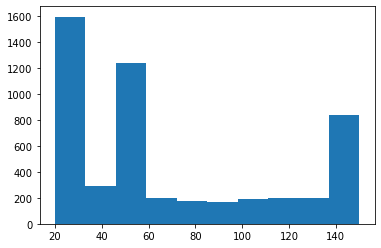

In [39]:
plt.hist(input_model3)
plt.show

4729 [50.0,...,150.0]


AttributeError: 'Mesh' object has no attribute 'paraDomain'

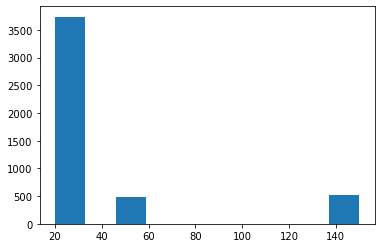

In [25]:
print(input_model)
plt.hist(input_model)
plt.show
print(mesh.paraDomain.cellCenters().array)

<function matplotlib.pyplot.show(close=None, block=None)>

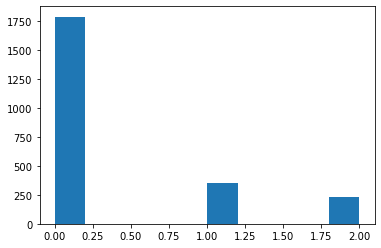

In [31]:
classes = []
resistivity_values = []
for pair in resistivity_map:
    resistivity_values.append(pair[1])
#print(resistivity_values)

for value in input_model2:
    #print(value)
    res_diff = np.abs(value*np.ones_like(resistivity_values)-resistivity_values)
    #print(res_diff)
    res_index = np.argmin(res_diff)
    #print(res_index)
    classes.append(res_index)

plt.hist(classes)
plt.show
